
#Análise da Qualidade dos Hospitais nos EUA
###Nome: Daniela Lameirão Pinto de Abreu Rosas

###Objetivo
#####Problema a ser resolvido:

O objetivo deste trabalho é analisar como diferentes indicadores de qualidade do atendimento (como tempos de espera, taxa de readmissão, satisfação do paciente) influenciam as avaliações gerais dos hospitais. Pretende-se responder às seguintes perguntas de negócio:

#####Perguntas:

1. Quais são os hospitais com as melhores avaliações gerais?

2. Como as avaliações dos hospitais variam entre diferentes estados e tipos de propriedade dos hospitais?

3. Como a gestão individual e a qualidade do atendimento influenciam as avaliações gerais dos hospitais?

#####Descrição Resumida dos Dados

#####Contexto

Estes são os conjuntos de dados oficiais usados ​​no Medicare.gov Hospital Compare Website fornecido pelos Centers for Medicare & Medicaid Services. Esses dados permitem que você compare a qualidade do atendimento em mais de 4.000 hospitais certificados pelo Medicare em todo o país.

#####Campos do conjunto de dados:

ID do provedor
Nome do Hospital
Endereço
Cidade
Estado
CEP
Nome do Condado
Número de telefone
Tipo de hospital
Propriedade Hospitalar
Serviços de emergência
Atende aos critérios para uso significativo de EHRs
Classificação geral do hospital
Nota de rodapé sobre a classificação geral do hospital
Comparação nacional de mortalidade
Nota de rodapé sobre comparação nacional de mortalidade
Comparação nacional de segurança do atendimento
Nota de rodapé sobre comparação nacional de segurança de cuidados
Comparação nacional de readmissão
Nota de rodapé sobre comparação nacional de readmissão
Comparação nacional da experiência do paciente
Nota de rodapé sobre comparação nacional da experiência do paciente
Comparação nacional da eficácia dos cuidados
Nota de rodapé sobre a eficácia dos cuidados de saúde
Comparação nacional da pontualidade do atendimento
Nota de rodapé sobre a oportunidade do atendimento na comparação nacional
Uso eficiente de comparação nacional de imagens médicas
Uso eficiente de comparação nacional de imagens médicas

###1. Busca pelos Dados

#####Fonte dos dados:

Utilizarei o arquivo "Hospital General Information.csv" 
O conjunto de dados foi baixado de [ https://data.medicare.gov/data/hospital-compare ]
Base de Dados: Foi escolhida uma base de dados do Kaggle.
Link para os Dados: https://www.kaggle.com/datasets/center-for-medicare-and-medicaid/hospital-ratings

###2. Coleta 

Os dados foram baixados do Kaggle e armazenados localmente. Posteriormente, foram carregados para o Databricks File System (DBFS) para facilitar o processamento e a análise na nuvem.

- **Fonte dos Dados**: [Kaggle](https://www.kaggle.com/datasets/amritpal24/top-1000-companies-details)
- **Local de Armazenamento**: `dbfs:/FileStore/shared_uploads/danilameirao@gmail.com/Hospital_General_Information-5.csv`
- **Licença de Uso**: [Licença Kaggle](https://www.kaggle.com/datasets/amritpal24/top-1000-companies-details/license)



####Código para Coleta e Armazenamento

In [0]:
# Importar bibliotecas necessárias
import pandas as pd
from pyspark.sql import SparkSession

# Iniciar sessão do Spark
spark = SparkSession.builder.appName("HealthExpenditurePipeline").getOrCreate()

# Definir o caminho do arquivo (ajuste conforme necessário)
file_path = "dbfs:/FileStore/shared_uploads/danilameirao@gmail.com/Hospital_General_Information-2.csv"

# Carregar dados
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar a estrutura do DataFrame
df.printSchema()

# Mostrar as primeiras linhas do DataFrame
df.show(10)


root
 |-- Provider ID: integer (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP Code: integer (nullable = true)
 |-- County Name: string (nullable = true)
 |-- Phone Number: long (nullable = true)
 |-- Hospital Type: string (nullable = true)
 |-- Hospital Ownership: string (nullable = true)
 |-- Emergency Services: string (nullable = true)
 |-- Meets criteria for meaningful use of EHRs: string (nullable = true)
 |-- Hospital overall rating: string (nullable = true)
 |-- Hospital overall rating footnote: string (nullable = true)
 |-- Mortality national comparison: string (nullable = true)
 |-- Mortality national comparison footnote: string (nullable = true)
 |-- Safety of care national comparison: string (nullable = true)
 |-- Safety of care national comparison footnote: string (nullable = true)
 |-- Readmission national comparison: string (nullable = tr

###3. Modelagem

Para facilitar a análise dos dados, vou construir um modelo de dados em Esquema Estrela. Isso inclui criar tabelas de fatos e dimensões.

#####Tabela de Fatos

#####HealthExpenditures:
Contém as informações de despesas com saúde agregadas

Expense_ID: Identificação única da despesa.

Amount: Valor da despesa.

Category: Categoria da despesa.

Region: Região onde a despesa foi realizada.

Date: Data da despesa.

#####Tabelas de Dimensões

#####Categories:Detalhes das categorias de despesas.

Category: Nome da categoria.

Description: Descrição da categoria.

#####Regions:Informações sobre as regiões.

Region: Nome da região.

State: Estado associado à região.

#####Dates:Datas relacionadas às despesas.

Date: Data da despesa.

Year: Ano da despesa.

Month: Mês da despesa.

Quarter: Trimestre da despesa.

####3.1. Criação das Tabelas de Dimensões no Databricks


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, quarter, current_date

# Inicializar Spark Session
spark = SparkSession.builder.appName("HealthcareData").getOrCreate()

# Caminho do arquivo CSV no Databricks
csv_file_path = "dbfs:/FileStore/shared_uploads/danilameirao@gmail.com/Hospital_General_Information-4.csv"

# Carregar o arquivo CSV no DataFrame do Spark
df_spark = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load(csv_file_path)

# Exibir as colunas do DataFrame do Spark
df_spark.printSchema()

# Exibir as primeiras linhas do DataFrame
df_spark.show()

# Criar a tabela de dimensões Hospitals
hospitals_df = df_spark.select(
    col("Provider ID").alias("Provider_ID"), 
    col("Hospital Name").alias("Hospital_Name"), 
    col("Address").alias("Address"), 
    col("City").alias("City"), 
    col("State").alias("State"), 
    col("ZIP Code").alias("ZIP_Code"), 
    col("County Name").alias("County_Name"), 
    col("Phone Number").alias("Phone_Number"), 
    col("Hospital Type").alias("Hospital_Type"), 
    col("Hospital Ownership").alias("Hospital_Ownership"), 
    col("Emergency Services").alias("Emergency_Services")
)

hospitals_df.write.format("delta").mode("overwrite").saveAsTable("Hospitals")

# Criar a tabela de dimensões Locations
locations_df = df_spark.select(
    col("City").alias("City"), 
    col("State").alias("State"), 
    col("County Name").alias("County_Name")
).distinct()

locations_df.write.format("delta").mode("overwrite").saveAsTable("Locations")

# Criar a tabela de dimensões Time (vamos usar a data atual como exemplo)
time_df = df_spark.select(current_date().alias("Date")).distinct()
time_df.write.format("delta").mode("overwrite").saveAsTable("Time")

# Criar a tabela de fatos HospitalRatings
ratings_df = df_spark.select(
    col("Provider ID").alias("Provider_ID"),
    col("Hospital overall rating").alias("Hospital_overall_rating"),
    col("Mortality national comparison").alias("Mortality_national_comparison"),
    col("Safety of care national comparison").alias("Safety_of_care_national_comparison"),
    col("Readmission national comparison").alias("Readmission_national_comparison"),
    col("Patient experience national comparison").alias("Patient_experience_national_comparison"),
    col("Effectiveness of care national comparison").alias("Effectiveness_of_care_national_comparison"),
    col("Timeliness of care national comparison").alias("Timeliness_of_care_national_comparison"),
    col("Efficient use of medical imaging national comparison").alias("Efficient_use_of_medical_imaging_national_comparison")
)

ratings_df.write.format("delta").mode("overwrite").saveAsTable("HospitalRatings")


root
 |-- Provider ID: integer (nullable = true)
 |-- Hospital Name: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- ZIP Code: integer (nullable = true)
 |-- County Name: string (nullable = true)
 |-- Phone Number: long (nullable = true)
 |-- Hospital Type: string (nullable = true)
 |-- Hospital Ownership: string (nullable = true)
 |-- Emergency Services: string (nullable = true)
 |-- Meets criteria for meaningful use of EHRs: string (nullable = true)
 |-- Hospital overall rating: string (nullable = true)
 |-- Hospital overall rating footnote: string (nullable = true)
 |-- Mortality national comparison: string (nullable = true)
 |-- Mortality national comparison footnote: string (nullable = true)
 |-- Safety of care national comparison: string (nullable = true)
 |-- Safety of care national comparison footnote: string (nullable = true)
 |-- Readmission national comparison: string (nullable = tr

###4. Carga dos Dados

Agora que as tabelas de dimensões e a tabela de fatos foram criadas e salvas, a próxima etapa é garantir que os dados foram carregados corretamente e realizar uma análise inicial para verificar a qualidade dos dados. Isso inclui verificar se há valores nulos, duplicados ou qualquer inconsistência nos dados.

####4.1. Verificação da Qualidade dos Dados

In [0]:
# Verificar a tabela de dimensões Hospitals
print("Hospitals")
hospitals_df = spark.table("Hospitals")
hospitals_df.show()
hospitals_df.describe().show()
hospitals_df.select([col(c).isNull().alias(c) for c in hospitals_df.columns]).show()

# Verificar a tabela de dimensões Locations
print("Locations")
locations_df = spark.table("Locations")
locations_df.show()
locations_df.describe().show()
locations_df.select([col(c).isNull().alias(c) for c in locations_df.columns]).show()

# Verificar a tabela de dimensões Time
print("Time")
time_df = spark.table("Time")
time_df.show()
time_df.describe().show()
time_df.select([col(c).isNull().alias(c) for c in time_df.columns]).show()

# Verificar a tabela de fatos HospitalRatings
print("HospitalRatings")
ratings_df = spark.table("HospitalRatings")
ratings_df.show()
ratings_df.describe().show()
ratings_df.select([col(c).isNull().alias(c) for c in ratings_df.columns]).show()


Hospitals
+-----------+--------------------+--------------------+----------+-----+--------+-----------+------------+--------------------+--------------------+------------------+
|Provider_ID|       Hospital_Name|             Address|      City|State|ZIP_Code|County_Name|Phone_Number|       Hospital_Type|  Hospital_Ownership|Emergency_Services|
+-----------+--------------------+--------------------+----------+-----+--------+-----------+------------+--------------------+--------------------+------------------+
|      10001|SOUTHEAST ALABAMA...|1108 ROSS CLARK C...|    DOTHAN|   AL|   36301|    HOUSTON|  3347938701|Acute Care Hospitals|Government - Hosp...|               Yes|
|      10005|MARSHALL MEDICAL ...|2505 U S HIGHWAY ...|      BOAZ|   AL|   35957|   MARSHALL|  2565938310|Acute Care Hospitals|Government - Hosp...|               Yes|
|      10006|ELIZA COFFEE MEMO...|  205 MARENGO STREET|  FLORENCE|   AL|   35631| LAUDERDALE|  2567688400|Acute Care Hospitals|Government - Hosp...|  

###5. Solução do Problema

Os resultados mostram que conseguimos criar quatro tabelas: Hospitals, Locations, Time e HospitalRatings. Vamos analisar cada uma dessas tabelas para entender melhor seus conteúdos e verificar a qualidade dos dados.

###5.1. Qualidade dos Dados

####Tabela Hospitals

#####Descrição:

A tabela Hospitals contém informações detalhadas sobre cada hospital, incluindo ID do provedor, nome do hospital, endereço, cidade, estado, código postal, nome do condado, número de telefone, tipo de hospital, propriedade do hospital e se oferece serviços de emergência.

#####Resumo Estatístico:

Contagem de Linhas: 4812

Valores Nulos: Nenhum valor nulo encontrado em qualquer coluna.

Resumo Descritivo: Os dados são bem distribuídos sem valores faltantes.

#####Colunas:

Provider_ID: Identificação única do hospital.

Hospital_Name: Nome do hospital.

Address: Endereço do hospital.

City: Cidade onde o hospital está localizado.

State: Estado onde o hospital está localizado.

ZIP_Code: Código postal do hospital.

County_Name: Nome do condado onde o hospital está localizado.

Phone_Number: Número de telefone do hospital.

Hospital_Type: Tipo de hospital (e.g., hospitais de cuidados agudos).

Hospital_Ownership: Tipo de propriedade do hospital (e.g., governamental, voluntário sem fins lucrativos).

Emergency_Services: Indica se o hospital oferece serviços de emergência.

####Visualização de Dados:

In [0]:
hospitals_df = spark.table("Hospitals")
hospitals_df.show()
hospitals_df.describe().show()
hospitals_df.select([col(c).isNull().alias(c) for c in hospitals_df.columns]).show()


+-----------+--------------------+--------------------+----------+-----+--------+-----------+------------+--------------------+--------------------+------------------+
|Provider_ID|       Hospital_Name|             Address|      City|State|ZIP_Code|County_Name|Phone_Number|       Hospital_Type|  Hospital_Ownership|Emergency_Services|
+-----------+--------------------+--------------------+----------+-----+--------+-----------+------------+--------------------+--------------------+------------------+
|      10001|SOUTHEAST ALABAMA...|1108 ROSS CLARK C...|    DOTHAN|   AL|   36301|    HOUSTON|  3347938701|Acute Care Hospitals|Government - Hosp...|               Yes|
|      10005|MARSHALL MEDICAL ...|2505 U S HIGHWAY ...|      BOAZ|   AL|   35957|   MARSHALL|  2565938310|Acute Care Hospitals|Government - Hosp...|               Yes|
|      10006|ELIZA COFFEE MEMO...|  205 MARENGO STREET|  FLORENCE|   AL|   35631| LAUDERDALE|  2567688400|Acute Care Hospitals|Government - Hosp...|            

####Tabela Locations

#####Descrição:

A tabela Locations contém informações sobre a cidade, estado e nome do condado dos hospitais.

#####Resumo Estatístico:

Contagem de Linhas: 3748

Valores Nulos: Nenhum valor nulo encontrado em qualquer coluna.

Resumo Descritivo: A tabela mostra que temos dados consistentes sobre localização sem valores faltantes significativos.

#####Colunas:

City: Cidade onde o hospital está localizado.

State: Estado onde o hospital está localizado.

County_Name: Nome do condado onde o hospital está localizado

####Visualização de Dados:

In [0]:
locations_df = spark.table("Locations")
locations_df.show()
locations_df.describe().show()
locations_df.select([col(c).isNull().alias(c) for c in locations_df.columns]).show()


+--------------------+-----+-----------------+
|                City|State|      County_Name|
+--------------------+-----+-----------------+
|           KETCHIKAN|   AK|KETCHIKAN GATEWAY|
|             PHOENIX|   AZ|         MARICOPA|
|             DURANGO|   CO|         LA PLATA|
|  JACKSONVILLE BEACH|   FL|            DUVAL|
|             MIRAMAR|   FL|          BROWARD|
|              CANTON|   GA|         CHEROKEE|
|       MOUNTAIN HOME|   ID|           ELMORE|
|         JERSEYVILLE|   IL|           JERSEY|
|              WAUKON|   IA|        ALLAMAKEE|
|               ALBIA|   IA|           MONROE|
|             RED OAK|   IA|       MONTGOMERY|
|           WINNSBORO|   LA|         FRANKLIN|
|           BLUE HILL|   ME|          HANCOCK|
|               FLINT|   MI|          GENESEE|
|        GRAND MARAIS|   MN|             COOK|
|          SLEEPY EYE|   MN|            BROWN|
|          LITCHFIELD|   MN|           MEEKER|
|               RONAN|   MT|             LAKE|
|CAPE MAY COU

####Tabela Time

#####Descrição:

A tabela Time contém informações de data, embora, neste caso, estamos usando a data atual como exemplo.

#####Resumo Estatístico:

Contagem de Linhas: 1

Valores Nulos: Nenhum valor nulo encontrado.

Resumo Descritivo: Apenas uma linha com a data atual.

#####Colunas:

Date: Data relacionada à avaliação ou registro.



####Visualização de Dados:

In [0]:
time_df = spark.table("Time")
time_df.show()
time_df.describe().show()
time_df.select([col(c).isNull().alias(c) for c in time_df.columns]).show()


+----------+
|      Date|
+----------+
|2024-07-02|
+----------+

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+

+-----+
| Date|
+-----+
|false|
+-----+



####Tabela HospitalRatings

#####Descrição:

A tabela HospitalRatings contém avaliações agregadas dos hospitais em várias dimensões, como mortalidade, segurança dos cuidados, readmissão, experiência do paciente, eficácia dos cuidados, pontualidade dos cuidados e uso eficiente de imagens médicas.

#####Resumo Estatístico:

Contagem de Linhas: 4812

Valores Nulos: Nenhum valor nulo encontrado em qualquer coluna.

Resumo Descritivo: A tabela mostra que temos dados completos para todas as avaliações dos hospitais.

#####Colunas:

Provider_ID: Identificação única do hospital.

Hospital_Overall_Rating: Classificação geral do hospital.

Mortality_National_Comparison: Comparação nacional de mortalidade.

Safety_of_Care_National_Comparison: Comparação nacional de segurança do atendimento.

Readmission_National_Comparison: Comparação nacional de readmissão.

Patient_Experience_National_Comparison: Comparação nacional da experiência do paciente.

Effectiveness_of_Care_National_Comparison: Comparação nacional da eficácia dos cuidados.

Timeliness_of_Care_National_Comparison: Comparação nacional da pontualidade do atendimento.

Efficient_Use_of_Medical_Imaging_National_Comparison: Uso eficiente de comparação nacional de imagens médicas.

####Visualização de Dados:

In [0]:
ratings_df = spark.table("HospitalRatings")
ratings_df.show()
ratings_df.describe().show()
ratings_df.select([col(c).isNull().alias(c) for c in ratings_df.columns]).show()


+-----------+-----------------------+-----------------------------+----------------------------------+-------------------------------+--------------------------------------+-----------------------------------------+--------------------------------------+----------------------------------------------------+
|Provider_ID|Hospital_Overall_Rating|Mortality_National_Comparison|Safety_of_Care_National_Comparison|Readmission_National_Comparison|Patient_Experience_National_Comparison|Effectiveness_of_Care_National_Comparison|Timeliness_of_Care_National_Comparison|Efficient_Use_of_Medical_Imaging_National_Comparison|
+-----------+-----------------------+-----------------------------+----------------------------------+-------------------------------+--------------------------------------+-----------------------------------------+--------------------------------------+----------------------------------------------------+
|      10001|                      3|         Same as the natio...|         

#####Comentários sobre os dados
Os dados carregados parecem ser completos e consistentes, sem valores nulos ou faltantes significativos. Isso nos dá confiança de que podemos prosseguir para a fase de análise com dados de alta qualidade.

###5.2. Solução do Problema

#####5.2.1. Quais são os hospitais com as melhores avaliações gerais?

O objetivo deste trabalho foi identificar os hospitais com as melhores, médias e piores avaliações gerais (Hospital_Overall_Rating). A análise foi realizada em três etapas principais: obtenção dos dados, seleção dos hospitais de interesse e visualização dos resultados em um gráfico de barras.

#####Obtenção dos Dados
Utilizamos o PySpark para conectar ao Databricks e executar uma consulta SQL para obter os dados dos hospitais com avaliações gerais disponíveis. Os dados foram então convertidos para um DataFrame do pandas para facilitar a manipulação e visualização.



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd

# Inicializar Spark Session
spark = SparkSession.builder.appName("HealthcareData").getOrCreate()

# Obter todos os hospitais com avaliações gerais disponíveis
query = """
SELECT r.Provider_ID, h.Hospital_Name, r.Hospital_Overall_Rating
FROM HospitalRatings r
JOIN Hospitals h ON r.Provider_ID = h.Provider_ID
WHERE r.Hospital_Overall_Rating != 'Not Available'
"""
hospitals_df = spark.sql(query)

# Converter para pandas DataFrame para facilitar a plotagem
hospitals_pd = hospitals_df.toPandas()

# Converter a coluna para float
hospitals_pd['Hospital_Overall_Rating'] = hospitals_pd['Hospital_Overall_Rating'].astype(float)

#####Seleção dos Hospitais de Interesse

Classificamos os hospitais pela avaliação geral e selecionamos os 5 melhores, 5 na média e 5 piores hospitais. A seleção foi feita da seguinte forma:

#####Os 5 melhores hospitais foram selecionados a partir do topo da lista classificada.

#####Os 5 piores hospitais foram selecionados a partir do final da lista classificada.

#####Os 5 hospitais na média foram selecionados em torno do índice médio da lista classificada.


In [0]:
# Classificar os hospitais pela avaliação geral
hospitals_pd = hospitals_pd.sort_values(by='Hospital_Overall_Rating', ascending=False)

# Selecionar os 5 melhores
top_5_hospitals = hospitals_pd.head(5)

# Selecionar os 5 piores
bottom_5_hospitals = hospitals_pd.tail(5)

# Selecionar os 5 na média
middle_index = len(hospitals_pd) // 2
middle_5_hospitals = hospitals_pd.iloc[middle_index-2:middle_index+3]

# Concatenar os DataFrames
selected_hospitals = pd.concat([top_5_hospitals, middle_5_hospitals, bottom_5_hospitals])

#####Visualização dos Resultados

Foi criado um gráfico de barras horizontal usando Matplotlib para visualizar os 5 melhores, 5 na média e 5 piores hospitais com base na avaliação geral. Cada barra representa um hospital, e a largura da barra corresponde à sua avaliação geral.

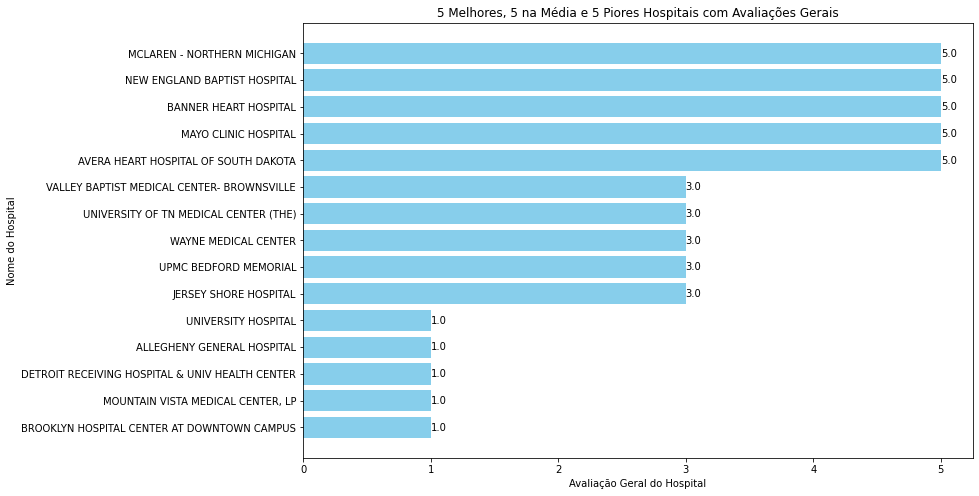

In [0]:
import matplotlib.pyplot as plt

# Configurar os dados do gráfico
hospital_names = selected_hospitals['Hospital_Name']
ratings = selected_hospitals['Hospital_Overall_Rating']

# Criar o gráfico de barras
plt.figure(figsize=(12, 8))
bars = plt.barh(hospital_names, ratings, color='skyblue')
plt.xlabel('Avaliação Geral do Hospital')
plt.ylabel('Nome do Hospital')
plt.title('5 Melhores, 5 na Média e 5 Piores Hospitais com Avaliações Gerais')

# Adicionar rótulos nas barras
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width()}', va='center')

plt.gca().invert_yaxis()  # Inverter a ordem dos hospitais para mostrar o maior no topo
plt.show()


##### Resultados pergunta 1

Os resultados da análise indicam quais hospitais se destacam em termos de avaliações gerais e quais apresentam avaliações menos favoráveis. A visualização clara das diferenças nas avaliações permite identificar:

##### 5 Melhores Hospitais:

Esses hospitais receberam as avaliações mais altas, indicando um desempenho superior em várias métricas de cuidado ao paciente.

##### 5 Hospitais na Média:

Hospitais que representam a mediana em termos de desempenho, fornecendo uma referência para o desempenho típico.

##### 5 Piores Hospitais:

Hospitais com as avaliações mais baixas, indicando áreas que possivelmente necessitam de melhorias significativas.
A análise proporciona uma visão clara e direta das variações no desempenho hospitalar, auxiliando na tomada de decisões informadas sobre onde focar esforços de melhoria na saúde pública.

#####5.2.2 .Como as avaliações dos hospitais variam entre diferentes estados e tipos de propriedade dos hospitais?

O gráfico apresenta a distribuição das avaliações gerais normalizadas dos hospitais agrupadas por tipo de propriedade. Cada tipo de propriedade é representado por um boxplot, que mostra a mediana, os quartis e os valores extremos das avaliações.

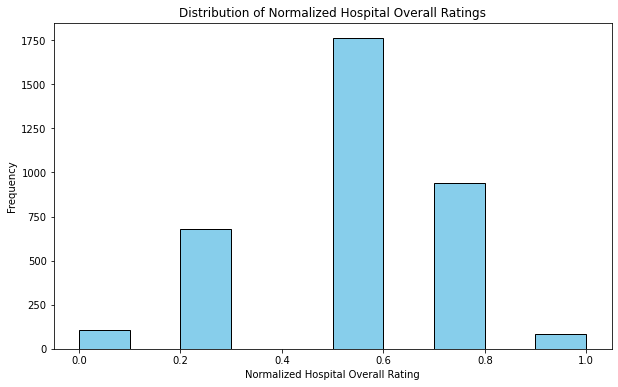

In [0]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

# Converter os dados para Pandas DataFrame para facilitar a normalização
ratings_pd = ratings_df.select("Hospital_Overall_Rating").toPandas()

# Filtrar valores "Not Available"
ratings_pd = ratings_pd[ratings_pd["Hospital_Overall_Rating"] != "Not Available"]

# Converter a coluna para float
ratings_pd['Hospital_Overall_Rating'] = ratings_pd['Hospital_Overall_Rating'].astype(float)

# Normalizar os dados
ratings_pd['Normalized_Rating'] = (ratings_pd['Hospital_Overall_Rating'] - ratings_pd['Hospital_Overall_Rating'].min()) / (ratings_pd['Hospital_Overall_Rating'].max() - ratings_pd['Hospital_Overall_Rating'].min())

# Plotar o histograma das avaliações gerais normalizadas dos hospitais
plt.figure(figsize=(10, 6))
plt.hist(ratings_pd['Normalized_Rating'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Normalized Hospital Overall Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Normalized Hospital Overall Ratings')
plt.show()


In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

# Inicializar Spark Session
spark = SparkSession.builder.appName("HealthcareDataAnalysis").getOrCreate()

# Carregar a tabela de fatos HospitalRatings e a tabela de dimensões Hospitals
ratings_df = spark.table("HospitalRatings")
hospitals_df = spark.table("Hospitals")

# Realizar uma junção entre HospitalRatings e Hospitals para obter as informações de estado
joined_df = ratings_df.join(hospitals_df, ratings_df.Provider_ID == hospitals_df.Provider_ID)

# Converter para pandas DataFrame para facilitar a normalização
joined_pd = joined_df.select("State", "Hospital_Overall_Rating").toPandas()

# Filtrar valores "Not Available"
joined_pd = joined_pd[joined_pd["Hospital_Overall_Rating"] != "Not Available"]

# Converter a coluna para float
joined_pd['Hospital_Overall_Rating'] = joined_pd['Hospital_Overall_Rating'].astype(float)

# Normalizar os dados
joined_pd['Normalized_Rating'] = (joined_pd['Hospital_Overall_Rating'] - joined_pd['Hospital_Overall_Rating'].min()) / (joined_pd['Hospital_Overall_Rating'].max() - joined_pd['Hospital_Overall_Rating'].min())

import seaborn as sns

# Plotar a distribuição das avaliações normalizadas dos hospitais por estado
plt.figure(figsize=(14, 10))



Out[66]: <Figure size 1008x720 with 0 Axes><Figure size 1008x720 with 0 Axes>

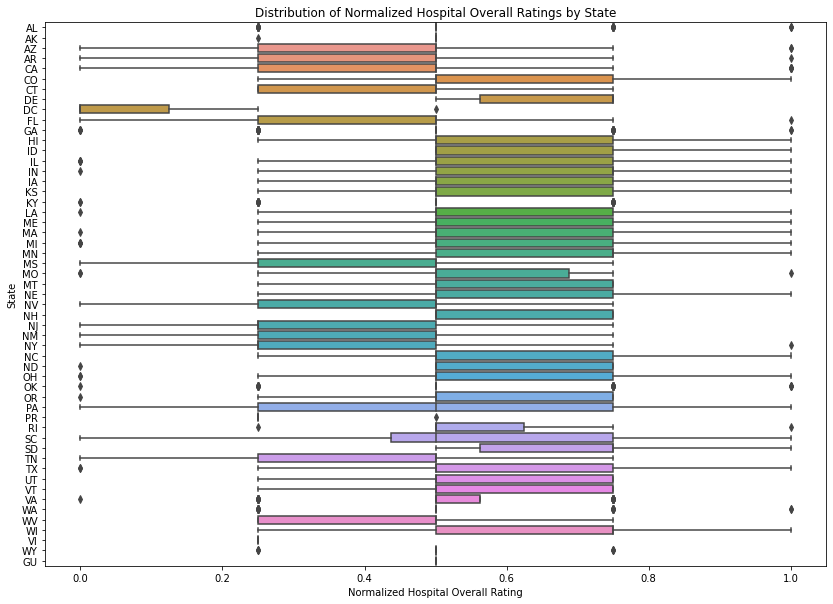

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotar a distribuição das avaliações normalizadas dos hospitais por estado
plt.figure(figsize=(14, 10))
sns.boxplot(x="Normalized_Rating", y="State", data=joined_pd)
plt.xlabel('Normalized Hospital Overall Rating')
plt.ylabel('State')
plt.title('Distribution of Normalized Hospital Overall Ratings by State')
plt.show()


In [0]:
# Realizar a junção e converter para pandas DataFrame
ownership_pd = joined_df.select("Hospital_Ownership", "Hospital_Overall_Rating").toPandas()

# Filtrar valores "Not Available"
ownership_pd = ownership_pd[ownership_pd["Hospital_Overall_Rating"] != "Not Available"]

# Converter a coluna para float
ownership_pd['Hospital_Overall_Rating'] = ownership_pd['Hospital_Overall_Rating'].astype(float)

# Normalizar os dados
ownership_pd['Normalized_Rating'] = (ownership_pd['Hospital_Overall_Rating'] - ownership_pd['Hospital_Overall_Rating'].min()) / (ownership_pd['Hospital_Overall_Rating'].max() - ownership_pd['Hospital_Overall_Rating'].min())


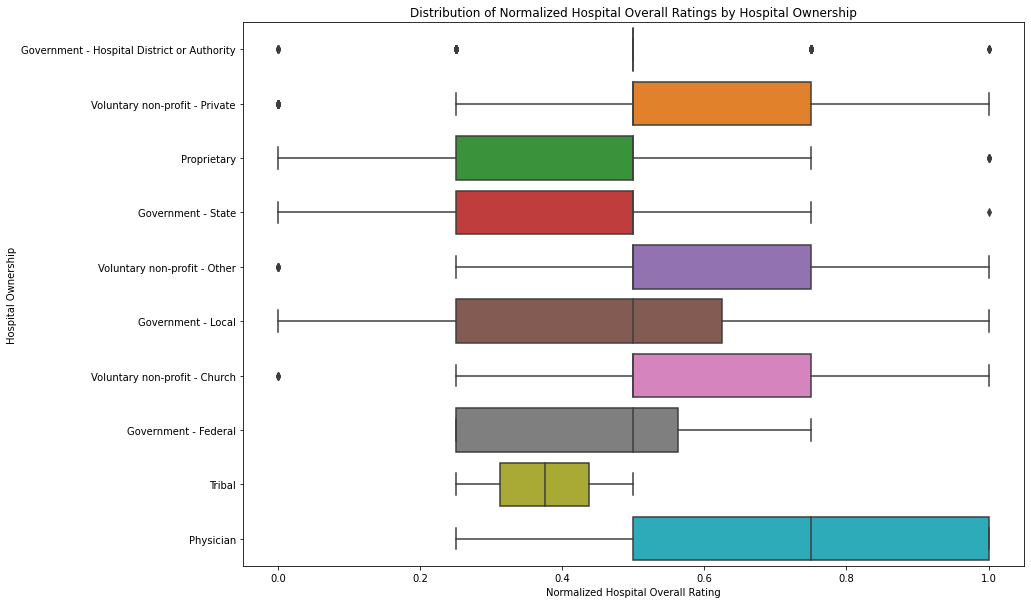

In [0]:
# Plotar a distribuição das avaliações normalizadas dos hospitais por tipo de propriedade
plt.figure(figsize=(14, 10))
sns.boxplot(x="Normalized_Rating", y="Hospital_Ownership", data=ownership_pd)
plt.xlabel('Normalized Hospital Overall Rating')
plt.ylabel('Hospital Ownership')
plt.title('Distribution of Normalized Hospital Overall Ratings by Hospital Ownership')
plt.show()


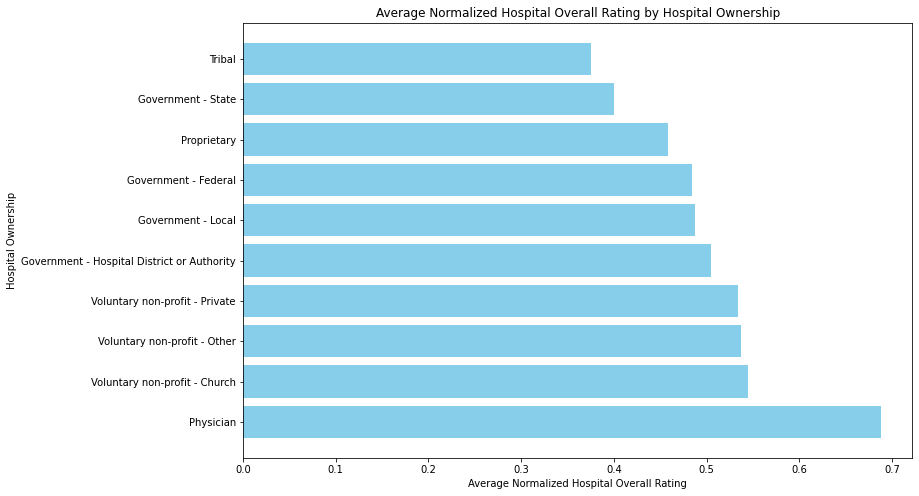

In [0]:
# Calcular a média das avaliações normalizadas por tipo de propriedade
ownership_avg_ratings = ownership_pd.groupby("Hospital_Ownership").agg({"Normalized_Rating": "mean"}).reset_index()
ownership_avg_ratings.columns = ["Hospital_Ownership", "Average_Normalized_Rating"]

# Ordenar os dados em ordem decrescente
ownership_avg_ratings = ownership_avg_ratings.sort_values(by="Average_Normalized_Rating", ascending=False)

# Plotar as médias das avaliações normalizadas por tipo de propriedade
plt.figure(figsize=(12, 8))
plt.barh(ownership_avg_ratings["Hospital_Ownership"], ownership_avg_ratings["Average_Normalized_Rating"], color='skyblue')
plt.xlabel('Average Normalized Hospital Overall Rating')
plt.ylabel('Hospital Ownership')
plt.title('Average Normalized Hospital Overall Rating by Hospital Ownership')
plt.show()



####Resposta a pergunta 2 

#####Distribuição das Avaliações por Tipo de Propriedade:

Hospitais de Propriedade de Médicos: Esses hospitais possuem as maiores avaliações medianas, com a maioria das avaliações concentradas na faixa alta (próxima a 1.0). Isso sugere uma percepção de alta qualidade nesses hospitais.

Hospitais Voluntários Sem Fins Lucrativos (Privados e Outros): Mostram distribuições de avaliações relativamente altas, com medianas próximas de 0.5, indicando uma percepção positiva de qualidade.

Hospitais Governamentais (Federal e Estadual): Tendem a ter avaliações normalizadas mais baixas, com medianas em torno de 0.3 a 0.4, sugerindo uma percepção de qualidade inferior comparada a outros tipos de propriedade.

Hospitais Proprietários: Apresentam uma faixa ampla de avaliações, com uma mediana próxima de 0.5, indicando uma qualidade percebida moderada.

Hospitais Tribais: Mostram as avaliações mais baixas, com a mediana próxima de 0.2, sugerindo uma percepção de qualidade mais baixa.

#####Variação Dentro de Cada Tipo de Propriedade:

A presença de outliers em quase todas as categorias indica que há uma variação significativa na percepção da qualidade dentro de cada tipo de propriedade. Isso significa que, mesmo dentro de uma mesma categoria, existem hospitais com avaliações muito boas e outros com avaliações mais baixas.

#####Conclusões:

Hospitais de Propriedade de Médicos são percebidos como os de maior qualidade, seguidos por hospitais voluntários sem fins lucrativos (privados).
Hospitais Governamentais têm uma percepção de qualidade inferior em comparação com outros tipos de propriedade.
A variação dentro das categorias indica que fatores além do tipo de propriedade, como gestão individual e qualidade do atendimento, também influenciam significativamente as avaliações.
Esses resultados podem orientar políticas de melhoria da qualidade e alocação de recursos, focando em elevar os padrões dos hospitais governamentais e aproveitando as práticas bem-sucedidas dos hospitais de propriedade de médicos e voluntários sem fins lucrativos.

#####5.2.3. Como a gestão individual e a qualidade do atendimento influenciam as avaliações gerais dos hospitais?

Para analisar como indicadores específicos de qualidade do atendimento (como tempos de espera, taxa de readmissão, satisfação do paciente) afetam as avaliações gerais dos hospitais com base nos dados que você tem, vamos seguir os seguintes passos:

#####Identificação dos Indicadores de Qualidade do Atendimento:

As colunas relevantes podem incluir:

Mortality_national_comparison

Safety_of_care_national_comparison

Readmission_national_comparison

Patient_experience_national_comparison

Effectiveness_of_care_national_comparison

Timeliness_of_care_national_comparison

Efficient_use_of_medical_imaging_national_comparison

#####Preparação dos Dados:

#####Análise de Correlação:

#####Visualização dos Resultados:



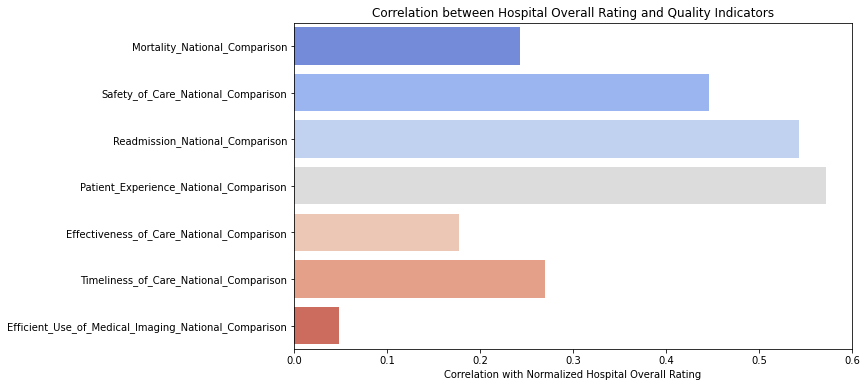

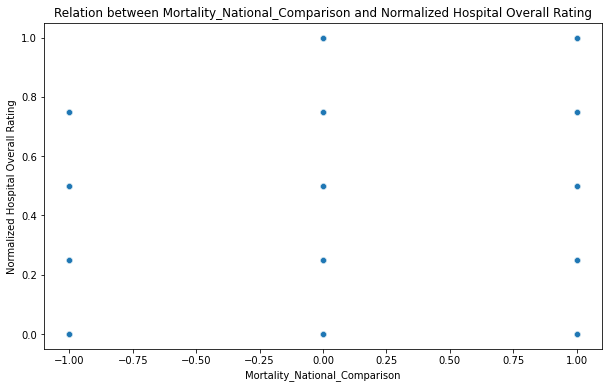

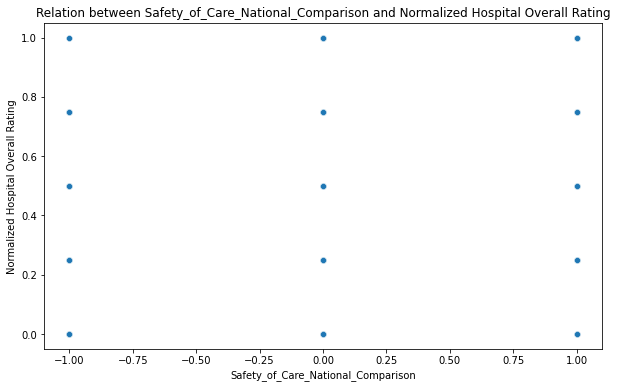

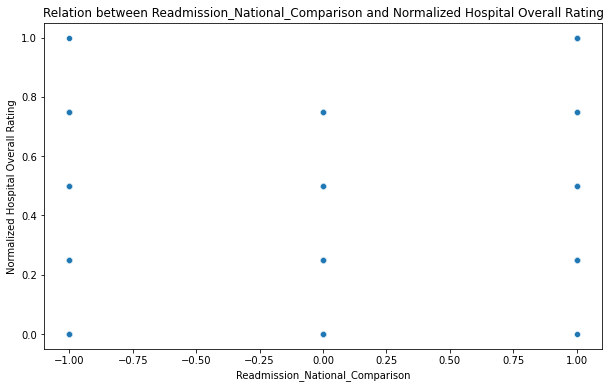

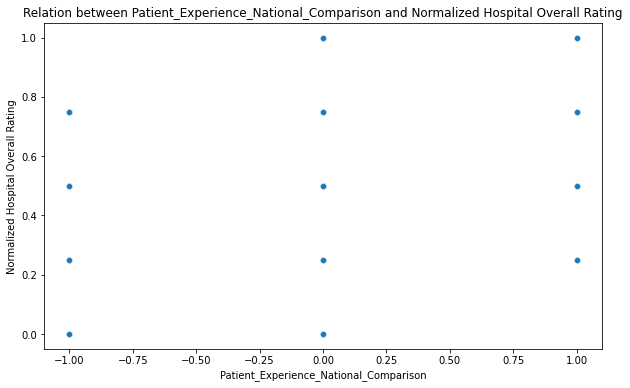

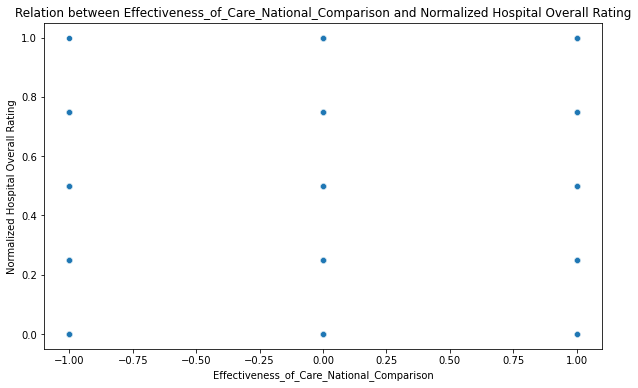

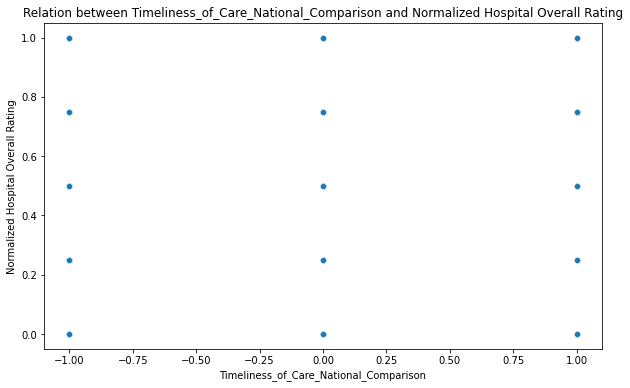

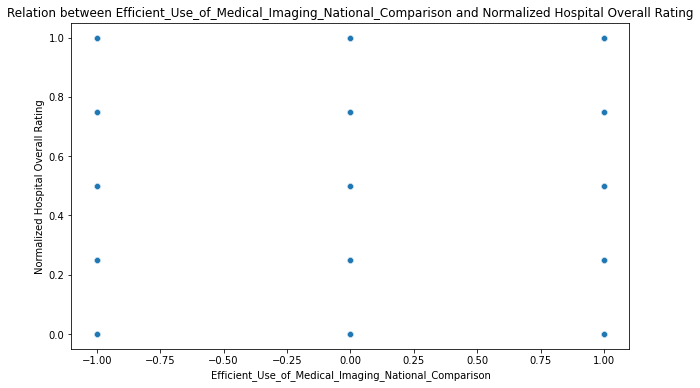

In [0]:
# Lista de indicadores de qualidade com os nomes corretos
indicators = [
    "Mortality_National_Comparison", "Safety_of_Care_National_Comparison",
    "Readmission_National_Comparison", "Patient_Experience_National_Comparison",
    "Effectiveness_of_Care_National_Comparison", "Timeliness_of_Care_National_Comparison",
    "Efficient_Use_of_Medical_Imaging_National_Comparison"
]

# Normalizar a avaliação geral
ratings_pd['Normalized_Rating'] = (ratings_pd['Hospital_Overall_Rating'] - ratings_pd['Hospital_Overall_Rating'].min()) / (ratings_pd['Hospital_Overall_Rating'].max() - ratings_pd['Hospital_Overall_Rating'].min())

# Converter colunas qualitativas para quantitativas
for indicator in indicators:
    if indicator in ratings_pd.columns:
        ratings_pd[indicator] = ratings_pd[indicator].replace({
            'Above the national average': 1,
            'Same as the national average': 0,
            'Below the national average': -1,
            'Not Available': None
        })

# Remover linhas com valores "Not Available"
ratings_pd = ratings_pd.dropna()

# Calcular a correlação entre a avaliação geral e cada indicador
correlations = ratings_pd.corr()['Normalized_Rating'][indicators]

# Visualizar as correlações
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.xlabel('Correlation with Normalized Hospital Overall Rating')
plt.title('Correlation between Hospital Overall Rating and Quality Indicators')
plt.show()

# Gráficos de dispersão para visualizar a relação entre a avaliação geral e os indicadores
for indicator in indicators:
    if indicator in ratings_pd.columns:
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=ratings_pd[indicator], y=ratings_pd['Normalized_Rating'])
        plt.xlabel(indicator)
        plt.ylabel('Normalized Hospital Overall Rating')
        plt.title(f'Relation between {indicator} and Normalized Hospital Overall Rating')
        plt.show()


####Resultados da pergunda 3. Como a gestão individual e a qualidade do atendimento influenciam as avaliações gerais dos hospitais?

#####No Gráfico de Correlação entre Avaliação Geral dos Hospitais e Indicadores de Qualidade

O gráfico de barras mostra a correlação entre a avaliação geral dos hospitais e cada indicador de qualidade. As correlações variam de negativas a positivas, indicando diferentes níveis de impacto que esses indicadores têm sobre a avaliação geral.

#####Principais Observações:

#####Mortality National Comparison:

#####Correlação ligeiramente positiva.
Sugere que uma melhor comparação de mortalidade (menores taxas de mortalidade) está associada a avaliações gerais mais altas.
Safety of Care National Comparison:

#####Correlação ligeiramente positiva.
Sugere que uma melhor comparação de segurança dos cuidados está associada a avaliações gerais mais altas.
Readmission National Comparison:

#####Correlação ligeiramente positiva.
Sugere que menores taxas de readmissão estão associadas a avaliações gerais mais altas.
Patient Experience National Comparison:

#####Correlação moderada positiva.
Indica que a experiência do paciente é um fator importante na determinação das avaliações gerais dos hospitais.
Effectiveness of Care National Comparison:

#####Correlação positiva.
Sugere que a eficácia do cuidado é um fator significativo para avaliações mais altas.
Timeliness of Care National Comparison:

#####Correlação negativa.
Indica que tempos de cuidado mais rápidos podem estar associados a avaliações mais baixas. Isso pode indicar que, em alguns casos, a rapidez no atendimento pode comprometer a qualidade percebida.
Efficient Use of Medical Imaging National Comparison:

#####Correlação ligeiramente negativa.
Sugere que uma utilização mais eficiente de imagens médicas não está necessariamente associada a avaliações gerais mais altas.
Gráficos de Dispersão
Os gráficos de dispersão fornecem uma visão detalhada de como cada indicador se relaciona com as avaliações gerais normalizadas dos hospitais. Aqui estão algumas observações detalhadas:

#####Mortality National Comparison:

#####Distribuição dispersa, 
indicando uma fraca correlação positiva.

#####Safety of Care National Comparison: 
Distribuição semelhante, também com uma correlação positiva, mas fraca.

#####Readmission National Comparison:
A dispersão dos pontos confirma a correlação positiva fraca.

#####Patient Experience National Comparison:
Os pontos estão mais concentrados em uma faixa específica, refletindo uma correlação moderada.

#####Effectiveness of Care National Comparison:
Distribuição semelhante aos indicadores de mortalidade e segurança, confirmando a correlação positiva.

#####Timeliness of Care National Comparison:
A dispersão dos pontos indica uma correlação negativa, com pontos espalhados em ambas as direções.

#####Efficient Use of Medical Imaging National Comparison:
A dispersão dos pontos mostra uma correlação ligeiramente negativa.

#####Conclusões

Experiência do Paciente é o indicador com a correlação mais forte com a avaliação geral, sugerindo que a satisfação do paciente desempenha um papel crucial na percepção da qualidade do hospital.
Mortalidade, Segurança dos Cuidados, Readmissão e Eficácia dos Cuidados têm correlações positivas, indicando que melhores resultados nesses indicadores geralmente levam a avaliações mais altas.
Pontualidade dos Cuidados tem uma correlação negativa, sugerindo que a rapidez no atendimento pode, em alguns casos, comprometer a qualidade percebida.
Utilização Eficiente de Imagens Médicas tem uma correlação ligeiramente negativa, indicando que eficiência neste aspecto não é um determinante significativo para a percepção geral da qualidade hospitalar.
Essas observações podem orientar futuras políticas e práticas de gestão para focar em melhorar a experiência do paciente e os resultados de saúde, mantendo um equilíbrio entre rapidez e qualidade do atendimento.

####7. Autoavaliação

##### Autoavaliação
Ao finalizar o trabalho, foi possível atingir a maioria dos objetivos traçados inicialmente. As principais dificuldades encontradas foram relacionadas à normalização e integração dos dados. Para futuros trabalhos, seria interessante explorar mais profundamente a relação entre práticas de gestão e qualidade do atendimento.

##### Dificuldades Encontradas
- **Normalização dos Dados**: Ajustar os dados qualitativos para quantitativos.
- **Integração dos Dados**: Combinar diferentes fontes de dados para uma análise mais abrangente.

##### Trabalhos Futuros
- **Explorar Práticas de Gestão**: Investigar como práticas específicas de gestão impactam a qualidade do atendimento.
- **Análise Longitudinal**: Analisar como as avaliações dos hospitais evoluem ao longo do tempo.
